In [ ]:
#Prediction using PySpark in Spark Cluster

In [ ]:
!pip install pyspark
!pip install pandas numpy scikit-learn yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=e7dc9588a5b07a4375c60b7e9d74390dfee97848a11e9f076bef56d098d701b2
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import yfinance as yf
from datetime import date
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# Download data for a specific stock
data = yf.download("GOOGL", start="2010-01-01", end=date.today())
data.reset_index(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, avg
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()
df = spark.createDataFrame(data)

# Example feature: 7-day moving average
windowSpec = Window.orderBy("Date").rowsBetween(-6, 0)
df = df.withColumn("MA_7", avg(col("Close")).over(windowSpec))

# Lag feature: Previous day's close price
df = df.withColumn("Previous_Close", lag(col("Close"), 1).over(Window.orderBy("Date")))


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Corrected feature_cols list with existing columns only
feature_cols = ["MA_7", "Previous_Close", "Volume"]  # Modify based on your DataFrame

# Remove the existing 'features' column if it exists
if "features" in df.columns:
    df = df.drop("features")

# Calculate mean for each column and create a dictionary
means = {col: df.select(col).na.drop().rdd.map(lambda r: r[0]).mean() for col in feature_cols}

# Fill missing values with the calculated means
df = df.na.fill(means)

# Assemble the features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Split data into training and test sets
train, test = df.randomSplit([0.8, 0.2], seed=12345)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Close")
lr_model = lr.fit(train)

# Make predictions on the test set
predictions = lr_model.transform(test)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")


RMSE: 1.3479133626914612


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])
             .build())

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train)
bestModel = cvModel.bestModel


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test set
predictions = lr_model.transform(test)

# Evaluate the model using different metrics
evaluator_rmse = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R-squared (R2): {r2}")
print(f"MAE: {mae}")


RMSE: 1.3479133626914612
R-squared (R2): 0.9990482920086728
MAE: 0.7762741867667919


In [ ]:
from pyspark.sql.functions import abs, col

# Add a column for the absolute percentage error
predictions = predictions.withColumn("abs_percent_error",
                                     abs((col("Close") - col("prediction")) / col("Close")) * 100)

# Calculate the MAPE
mape = predictions.select("abs_percent_error").agg({"abs_percent_error": "mean"}).collect()[0][0]

# Print the accuracy
accuracy = 100 - mape
print(f"Prediction Accuracy: {accuracy:.2f}%")


Prediction Accuracy: 98.79%


In [ ]:
# Assuming the latest data is included in the 'test' dataset

# Filter the most recent data point from the test dataset
latest_data = test.orderBy(col("Date").desc()).limit(1)

# Make a prediction using the trained model
today_prediction = lr_model.transform(latest_data)

# Extract and print the predicted price
predicted_price = today_prediction.select("prediction").collect()[0][0]
print(f"Predicted Price for Today: {predicted_price}")


Predicted Price for Today: 165.7825892832855


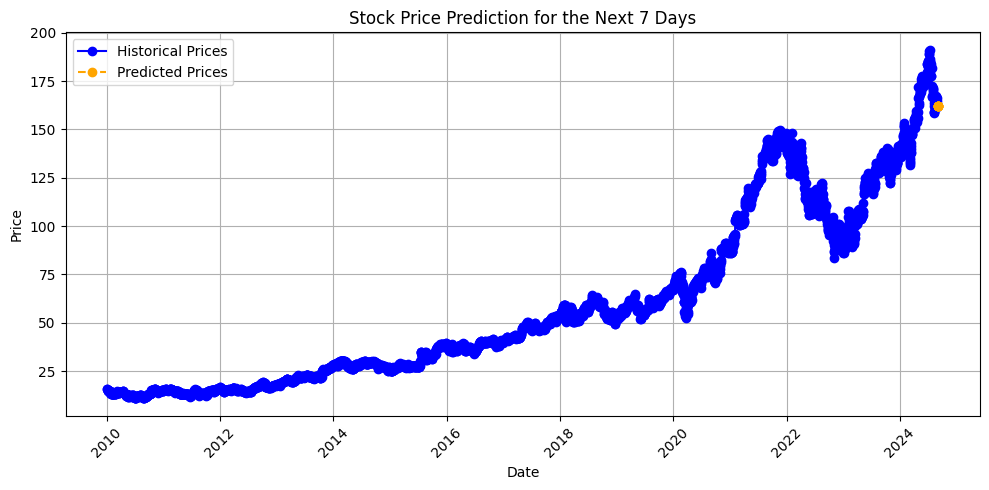

In [ ]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Assuming the training end date is the last date in your DataFrame
last_date = df.select(F.max("Date")).collect()[0][0]

# Generate future dates for the next 7 days
future_dates = pd.date_range(start=last_date, periods=8, freq='D')[1:]

# Create a DataFrame for future predictions
future_df = pd.DataFrame({"Date": future_dates})
future_spark_df = spark.createDataFrame(future_df)

# Prepare future features (example: keeping MA_7 and Previous_Close constant or applying a forecast model)
latest_close = df.select("Close").orderBy(F.col("Date").desc()).first()[0]

# Create future features assuming previous values remain constant
future_spark_df = future_spark_df.withColumn("MA_7", F.lit(latest_close)) \
                                 .withColumn("Previous_Close", F.lit(latest_close)) \
                                 .withColumn("Volume", F.lit(df.select(F.avg("Volume")).first()[0])) # Assume avg volume

# Transform future features using the trained VectorAssembler
future_features = assembler.transform(future_spark_df)

# Predict future prices using the trained model
future_predictions = lr_model.transform(future_features)

# Convert predictions to Pandas DataFrame for visualization
predicted_prices = future_predictions.select("Date", "prediction").toPandas()

# Plotting actual vs. predicted prices
plt.figure(figsize=(10, 5))

# Plot historical data
plt.plot(data['Date'], data['Close'], label='Historical Prices', marker='o', color='blue')

# Plot predicted data
plt.plot(predicted_prices['Date'], predicted_prices['prediction'], label='Predicted Prices', marker='o', linestyle='--', color='orange')

plt.title('Stock Price Prediction for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
#Prediction Without PySpark

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Download Historical Data
ticker_symbol = 'GOOGL'
data = yf.download(ticker_symbol, start="2010-01-01", end="2024-08-15")

# Step 2: Feature Engineering
data['Date'] = data.index
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Previous_Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

# Features and target variable
feature_cols = ['Previous_Close', 'Day', 'Month', 'Year']
X = data[feature_cols]
y = data['Close']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Prediction
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Predicting today's price
latest_data = data.tail(1)[feature_cols]
predicted_price = model.predict(latest_data)
print(f"Predicted Price for Today: {predicted_price[0]}")


[*********************100%%**********************]  1 of 1 completed

Root Mean Squared Error: 1.4640997696251294
Predicted Price for Today: 164.3207174944717
